<a href="https://www.kaggle.com/code/jaydendrino/notebook4caf11ef97?scriptVersionId=234725999" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install ultralytics
!pip install split-folders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 18.0 MB/s eta 0:00:00a 0:00:01


In [2]:
!nvidia-smi

Fri Apr 18 21:30:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import shutil
from ultralytics import YOLO  # For loading and running YOLOv8 models
from pathlib import Path
import torch  # For working with PyTorch tensors (used by YOLOv8)
import cv2  # For image and video processing
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualizing results
import splitfolders
import random
import pandas as pd
import seaborn as sns
from PIL import Image
import imghdr 

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# trash_dir = '/kaggle/input/garbage-classification-v2/garbage-dataset/trash/'
# paper_dir = '/kaggle/input/garbage-classification-v2/garbage-dataset/paper/'
# metal_dir = '/kaggle/input/garbage-classification-v2/garbage-dataset/metal/'
data_dir = '/kaggle/input/garbage-classification-v2/'

In [5]:
#clean working directory
def remove_folder_contents(folder):
    """Removes all files and subdirectories inside the given folder."""
    for item in os.listdir(folder):
        item_path = os.path.join(folder, item)
        try:
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)  # Remove file or symbolic link
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)  # Remove entire directory and its contents
        except Exception as e:
            print(f"Error deleting {item_path}: {e}")

# Usage
folder_path = '/kaggle/working'
remove_folder_contents(folder_path)

In [6]:
try:
    shutil.copytree(data_dir, '/kaggle/working/dataset')
#         shutil.copytree(trash_dir, '/kaggle/working/dataset/trash')
#         shutil.copytree(paper_dir, '/kaggle/working/dataset/paper')
#         shutil.copytree(metal_dir, '/kaggle/working/dataset/metal')
except Exception as e:
    print(e)
    pass


In [7]:
data_dir  = '/kaggle/working/dataset' #reassign data dir
experiment_name = "Transfer Learning"

In [8]:
#TODO double check what image formats are supported by yolo
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_ul = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_ul:
            print(f"{filepath} is a {img_type}, not accepted by ultralytics")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/garbage-dataset/paper/paper_719.jpg is not an image
/kaggle/working/dataset/garbage-dataset/paper/paper_719.jpg is a None, not accepted by ultralytics
/kaggle/working/dataset/garbage-dataset/paper/paper_1640.jpg is not an image
/kaggle/working/dataset/garbage-dataset/paper/paper_1640.jpg is a None, not accepted by ultralytics
/kaggle/working/dataset/garbage-dataset/paper/paper_2706.jpg is not an image
/kaggle/working/dataset/garbage-dataset/paper/paper_2706.jpg is a None, not accepted by ultralytics
/kaggle/working/dataset/garbage-dataset/paper/paper_1082.jpg is not an image
/kaggle/working/dataset/garbage-dataset/paper/paper_1082.jpg is a None, not accepted by ultralytics
/kaggle/working/dataset/garbage-dataset/paper/paper_2184.jpg is not an image
/kaggle/working/dataset/garbage-dataset/paper/paper_2184.jpg is a None, not accepted by ultralytics
/kaggle/working/dataset/garbage-dataset/paper/paper_2779.jpg is not an image
/kaggle/working/dataset/garbage-dataset/

In [9]:
#create folders for splitting dataset
os.mkdir('data')
os.chdir('data')

# os.getcwd()
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')
os.chdir('/kaggle/working/')
os.getcwd()

'/kaggle/working'

In [10]:
data_dir

'/kaggle/working/dataset'

In [11]:
#delete unused folder
import shutil

try:
    shutil.rmtree(data_dir)
except OSError as e:
    print(f"Error: {data_dir} : {e.strerror}")

Making sure each class has the same amount of images

IndexError: list index out of range

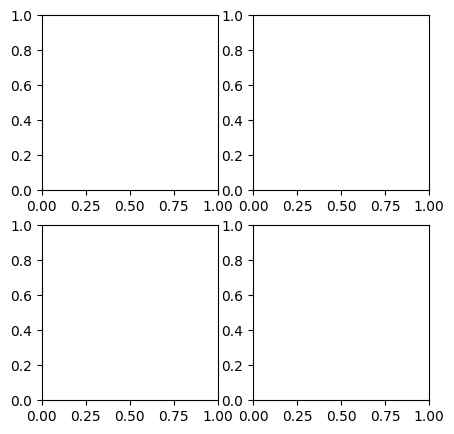

In [12]:
#TODO make sure each class has roughly the same amount of images
# Set the correct path to your training dataset
train_path = "/kaggle/working/data/train"  # Replace with the correct path to your dataset

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.ravel()  # Flatten the 2x2 grid into a 1D array

for i in np.arange(0, 4):  # Loop 4 times to display 4 images (including an empty plot)
    category = random.choice(os.listdir(train_path))  # Random class selection
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir))  # Random selection of an image from the class

    img = plt.imread(os.path.join(class_dir, image))  # Read the image
    axes[i].imshow(img)
    axes[i].set_title(category)  # Use the category name as the title
    axes[i].axis('off')

# Set the 4th subplot's axis to be off to leave it empty
axes[3].axis('off')

plt.show()

In [13]:
total = 0
for category in train_path.iterdir():  # Iterate through each category (folder)
    if category.is_dir():  # Check if it's a directory (category)
        count = 0
        for image in category.iterdir():  # Iterate through images in the category
            if image.is_file():  # Ensure it's a file (image)
                count += 1
                total += 1
        print(f"{category.name.title()}: {count}")

print(f"\nTotal number of train images: {total}")

AttributeError: 'str' object has no attribute 'iterdir'

In [ ]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

In [ ]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

In [ ]:
# Create a DataFrame
DF = pd.DataFrame({'Class names': class_names, 'Count': class_dis})

# Plot the bar chart
plt.figure(figsize=(7, 4))
ax = sns.barplot(x='Class names', y='Count', data=DF)

# Add labels on top of the bars
ax.bar_label(ax.containers[0])

# Rotate the x-axis labels to make them readable
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Improve the layout and avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
for category in train_path.iterdir():
    if category.is_dir():  # Ensure we're processing only directories (categories)
        count = 0
        delete = 0
        # Get list of images in the category
        images = list(category.iterdir())  # Get all images in the category

        count = len(images)  # Count the number of images in the category
        while count > 800:  # Delete images if there are more than 800
            random_image = random.choice(images)  # Randomly select an image
            random_image.unlink()  # Delete the image using pathlib
            delete += 1
            count -= 1
            images.remove(random_image)  # Remove the image from the list

        print(f'Deleted {delete} images in {category.name}')

In [ ]:
# Get the count of images for each class
class_dis = [len(list((train_path / name).iterdir())) for name in class_names if (train_path / name).is_dir()]

In [ ]:
# Create a DataFrame directly using a dictionary
DF = pd.DataFrame({'class': class_names, 'count': class_dis})

# Plot the bar chart
plt.figure(figsize=(7, 4))
ax = sns.barplot(x='class', y='count', data=DF)

# Add labels on top of the bars
ax.bar_label(ax.containers[0])

# Rotate the x-axis labels to make them readable
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Improve the layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
#TODO apply image transformations (i.e. resizing, cropping, random rotations, brightness/contrast adjustments, gaussian noise, normalization)

In [12]:
splitfolders.ratio("/kaggle/working/dataset/garbage-dataset", output = 'data', seed = 42, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 19709 files [00:03, 6306.58 files/s]


In [13]:
# from ultralytics import YOLO
# from ultralytics.data.utils import autosplit 

# #TODO switch to different splitting function that preserves class ratios when splitting (StratifiedShuffleSplit from sk-learn)
# autosplit(  
#     path="/kaggle/working/dataset/",
#     weights=(0.8, 0.1, 0.1),  # (train, validation, test) fractional splits
#     annotated_only=False,  # split only images with annotation file when True
# )

In [14]:
# yaml_content = """path: /kaggle/working/data/  # Base directory for dataset
# train: train  # Training dataset folder
# val: val  # Validation dataset folder
# test: test
# nc: 3  # Number of classes (change accordingly)
# names: ["metal", "paper", "trash"]  # Class names
# """

# # Write the content to a YAML file
# with open("/kaggle/working/dataset.yaml", "w") as file:
#     file.write(yaml_content)

# print("YAML file created successfully!")

In [15]:
print(os.listdir("/kaggle/working/"))  # Should include "dataset.yaml"

['dataset', 'data']


In [16]:
from ultralytics import YOLO

# Load a YOLOv8 model
model = YOLO("yolo11n-cls.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="/kaggle/working/data", epochs=1, imgsz=640, device=[0,1])

100%|██████████| 5.52M/5.52M [00:00<00:00, 122MB/s]


Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/kaggle/working/data, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=F

KeyboardInterrupt: 